In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iisc-umc-301-kaggle-competition-1/sample_submission.csv
/kaggle/input/iisc-umc-301-kaggle-competition-1/train.csv
/kaggle/input/iisc-umc-301-kaggle-competition-1/test.csv


In [4]:
import pandas as pd

train = pd.read_csv("/kaggle/input/iisc-umc-301-kaggle-competition-1/train.csv")
test = pd.read_csv("/kaggle/input/iisc-umc-301-kaggle-competition-1/test.csv")

print(train.shape)
print(test.shape)
train.head()
train.info()
train.describe()



(30000, 15)
(10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                30000 non-null  int64  
 1   song_duration_ms  26933 non-null  float64
 2   acousticness      26976 non-null  float64
 3   danceability      27033 non-null  float64
 4   energy            27065 non-null  float64
 5   instrumentalness  27034 non-null  float64
 6   key               26926 non-null  float64
 7   liveness          26978 non-null  float64
 8   loudness          27023 non-null  float64
 9   audio_mode        30000 non-null  int64  
 10  speechiness       30000 non-null  float64
 11  tempo             30000 non-null  float64
 12  time_signature    30000 non-null  int64  
 13  audio_valence     30000 non-null  float64
 14  song_popularity   30000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 3.4 MB


,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,30000.000000,26933.000000,26976.000000,27033.000000,27065.000000,27034.000000,26926.000000,26978.000000,27023.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000
mean,14999.500000,193309.698660,0.277219,0.571056,0.683746,0.036184,5.044752,0.198926,-7.418965,0.321167,0.093773,116.557754,3.393967,0.581015,0.36440
std,8660.398374,45713.675116,0.298704,0.189676,0.213314,0.149116,3.379665,0.151879,3.892481,0.466932,0.083474,26.188606,0.525198,0.237429,0.48127
min,0.000000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-30.170399,0.000000,0.015065,63.478876,2.000000,0.013398,0.00000
25%,7499.750000,166492.000000,0.039530,0.425141,0.538968,0.000952,2.000000,0.111956,-9.586576,0.000000,0.038421,97.000171,3.000000,0.398907,0.00000
50%,14999.500000,186908.000000,0.140486,0.607879,0.705028,0.001967,6.000000,0.136253,-6.356886,0.000000,0.055611,113.795116,3.000000,0.599059,0.00000
75%,22499.250000,215039.000000,0.484065,0.718443,0.870518,0.003226,8.000000,0.213505,-4.618818,1.000000,0.117877,128.497863,4.000000,0.760160,1.00000
max,29999.000000,470577.000000,1.065284,0.957131,1.033434,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,218.637439,5.000000,1.022283,1.00000


In [12]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def clean_data(df, is_test=False):
    # Make a copy to avoid modifying the original DataFrame
    df = df.copy()

    # =============================================================
    # STEP 1: IMPUTATION (Fill Missing Values First)
    # =============================================================
    # Identify columns with NaNs
    impute_cols = df.columns[df.isnull().any()].tolist()
    impute_cols = [col for col in impute_cols if col not in ['id', 'song_popularity']]

    if len(impute_cols) > 0:
        scaler = StandardScaler()
        df[impute_cols] = scaler.fit_transform(df[impute_cols])
        
        imputer = KNNImputer(n_neighbors=5)
        df[impute_cols] = imputer.fit_transform(df[impute_cols])
        
        df[impute_cols] = scaler.inverse_transform(df[impute_cols])

    # Handle 'key' separately if it has missing values
    if 'key' in df.columns and df['key'].isnull().any():
        df['key'].fillna(df['key'].mode()[0], inplace=True)

    # Re-clip values that might have been pushed outside the range by imputation
    # This is also part of cleaning the imputed data
    df.loc[:, 'acousticness'] = df['acousticness'].clip(0, 1)
    df.loc[:, 'liveness'] = df['liveness'].clip(0, 1)
    df.loc[:, 'audio_valence'] = df['audio_valence'].clip(0, 1)
    df.loc[:, 'instrumentalness'] = df['instrumentalness'].clip(0, 1)

    # =============================================================
    # STEP 2: OUTLIER REMOVAL (On Clean, Imputed Data)
    # =============================================================
    if not is_test:
        df = df[df["acousticness"].between(0, 1)]
        df = df[df['liveness'].between(0, 1)]
        df = df[df['audio_valence'].between(0, 1)]

    # =============================================================
    # STEP 3: FEATURE ENGINEERING
    # =============================================================
    # Encode key as sin/cos
    if 'key' in df.columns:
        df['key_sin'] = np.sin(2 * np.pi * df['key'] / 12.0)
        df['key_cos'] = np.cos(2 * np.pi * df['key'] / 12.0)

    df["log_duration"] = np.log1p(df["song_duration_ms"])
    df["log_tempo"] = np.log1p(df["tempo"])
    df["log_loudness"] = np.log1p(-df["loudness"])

    df["energy_to_acoustic"] = df["energy"] / (df["acousticness"] + 1e-6)
    df["dance_to_speech"] = df["danceability"] / (df["speechiness"] + 1e-6)

    df['is_instrumental'] = (df['instrumentalness'] > 0.5).astype(int)
    df["energy_if_instrumental"] = df["energy"] * df["is_instrumental"]
    df["speechiness_if_not_instrumental"] = df["speechiness"] * (1 - df["is_instrumental"])

    df["tempo_bin"] = pd.qcut(df["tempo"], q=10, labels=False, duplicates="drop")
    df["duration_bin"] = pd.qcut(df["song_duration_ms"], q=10, labels=False, duplicates="drop")

    df["tempo_sin"] = np.sin(2 * np.pi * df["tempo"] / df["tempo"].max())
    df["tempo_cos"] = np.cos(2 * np.pi * df["tempo"] / df["tempo"].max())

    df["perceived_intensity"] = np.power(10, df["loudness"]/10)

    # =============================================================
    # STEP 4: REMOVE REDUNDANT FEATURES
    # =============================================================
    features_to_drop = [
        'key',                  # Replaced by key_sin and key_cos
        'song_duration_ms',     # Replaced by log_duration and duration_bin
        'tempo',                # Replaced by multiple tempo features
        'loudness',             # Replaced by log_loudness and perceived_intensity
        'instrumentalness'      # Replaced by is_instrumental
    ]
    df.drop(columns=features_to_drop, inplace=True, errors='ignore')

    # Reorder columns to place target at the end (good practice)
    if 'song_popularity' in df.columns:
        cols = df.columns.tolist()
        cols.remove('song_popularity')
        df = df[cols + ['song_popularity']]

    return df
train = clean_data(train, is_test=False)
test = clean_data(test, is_test=True)

Fitting feature engineering on train...
Transforming train...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/co

Saved train_cleaned.csv
Preparing test features and transforming test...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/co

Saved test_cleaned.csv
Feature engineering complete. Output columns:
['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence', 'key_missing_flag', 'log_duration', 'duration_bin', 'log_tempo', 'tempo_bin', 'tempo_sin', 'tempo_cos', 'log_loudness', 'perceived_intensity', 'is_instrumental', 'energy_if_instrumental', 'speechiness_if_not_instrumental', 'energy_to_acoustic', 'dance_to_speech', 'energy_x_dance', 'key_sin', 'key_cos', 'time_signature_3', 'time_signature_4', 'audio_mode_1']


In [23]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               30000 non-null  int64  
 1   acousticness                     30000 non-null  float64
 2   danceability                     30000 non-null  float64
 3   energy                           30000 non-null  float64
 4   liveness                         30000 non-null  float64
 5   audio_mode                       30000 non-null  int64  
 6   speechiness                      30000 non-null  float64
 7   time_signature                   30000 non-null  int64  
 8   audio_valence                    30000 non-null  float64
 9   key_sin                          30000 non-null  float64
 10  key_cos                          30000 non-null  float64
 11  log_duration                     30000 non-null  float64
 12  duration_bin      

,id,acousticness,danceability,energy,liveness,audio_mode,speechiness,time_signature,audio_valence,key_sin,...,tempo_sin,tempo_cos,log_loudness,perceived_intensity,energy_to_acoustic,dance_to_speech,is_instrumental,energy_if_instrumental,speechiness_if_not_instrumental,song_popularity
0,0,0.642286,0.856520,0.707073,0.390957,0,0.082570,4,0.734642,-0.866025,...,-0.987116,-0.160007,3.279079,0.274215,1.100868,10.373189,0,0.0,0.082570,0
1,1,0.054866,0.733289,0.835545,0.436428,1,0.127358,3,0.711531,-0.866025,...,0.187568,-0.982252,3.293368,0.299436,15.228649,5.757630,0,0.0,0.127358,1
2,2,0.305463,0.188387,0.783524,0.170499,0,0.052282,3,0.425536,0.500000,...,-0.911997,0.410196,3.303902,0.319760,2.565024,3.603246,0,0.0,0.052282,0
3,3,0.488660,0.585234,0.552685,0.094805,0,0.035618,3,0.453597,0.000000,...,-0.529004,-0.848619,3.189517,0.162417,1.131019,16.430586,0,0.0,0.035618,0
4,4,0.493017,0.742250,0.740982,0.094891,0,0.050746,4,0.741311,-0.866025,...,-0.354490,-0.935060,3.383926,0.539002,1.502949,14.626442,0,0.0,0.050746,0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


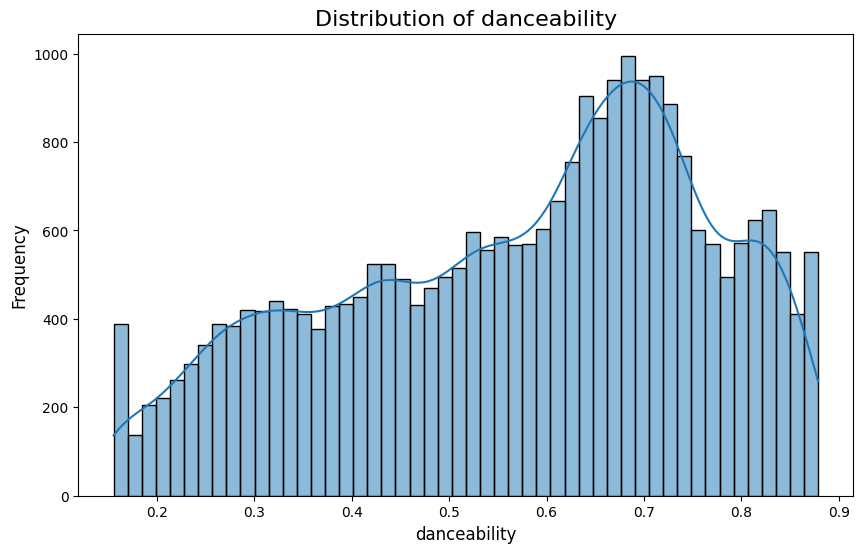

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Replace 'acousticness' with the name of the feature you want to plot ---
feature_name = 'danceability'

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the histogram using seaborn
sns.histplot(train[feature_name], kde=True, bins=50)

# Add a title and labels for clarity
plt.title(f'Distribution of {feature_name}', fontsize=16)
plt.xlabel(feature_name, fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the plot
plt.show()

[I 2025-09-04 14:13:46,640] A new study created in memory with name: no-name-a7dcab46-9a39-481f-9ed8-5fe963e38c96


Preparing data...
Starting Optuna optimization...


[I 2025-09-04 14:13:50,045] Trial 0 finished with value: 0.5646641516398316 and parameters: {'n_estimators': 735, 'learning_rate': 0.21019560089962688, 'max_depth': 5, 'subsample': 0.9727644493747046, 'colsample_bytree': 0.5226572575020914, 'min_child_weight': 3, 'gamma': 3.1501794663984937, 'scale_pos_weight': 3.287952205316953, 'reg_lambda': 2.415626002486929, 'reg_alpha': 0.6290350130007637}. Best is trial 0 with value: 0.5646641516398316.
[I 2025-09-04 14:13:55,111] Trial 1 finished with value: 0.5547113164207271 and parameters: {'n_estimators': 811, 'learning_rate': 0.11611563224661313, 'max_depth': 8, 'subsample': 0.958735049001064, 'colsample_bytree': 0.7988999219756582, 'min_child_weight': 6, 'gamma': 4.254980524239121, 'scale_pos_weight': 6.576012064258937, 'reg_lambda': 0.03146898968928989, 'reg_alpha': 0.010724492894956543}. Best is trial 0 with value: 0.5646641516398316.
[I 2025-09-04 14:13:59,100] Trial 2 finished with value: 0.5654726671730669 and parameters: {'n_estimato

Best trial:
{'n_estimators': 604, 'learning_rate': 0.08086678701188263, 'max_depth': 2, 'subsample': 0.7125741048902211, 'colsample_bytree': 0.8582404180699854, 'min_child_weight': 4, 'gamma': 1.3456114029673945, 'scale_pos_weight': 3.4955866069662322, 'reg_lambda': 0.002865972697562825, 'reg_alpha': 0.001710313739509163}

Retraining with best parameters using 7-Fold CV...
--- Fold 1/7 ---
Fold 1 -> Train AUC: 0.6562, Validation AUC: 0.5662
--- Fold 2/7 ---
Fold 2 -> Train AUC: 0.6565, Validation AUC: 0.5644
--- Fold 3/7 ---
Fold 3 -> Train AUC: 0.6564, Validation AUC: 0.5740
--- Fold 4/7 ---
Fold 4 -> Train AUC: 0.6561, Validation AUC: 0.5795
--- Fold 5/7 ---
Fold 5 -> Train AUC: 0.6572, Validation AUC: 0.5620
--- Fold 6/7 ---
Fold 6 -> Train AUC: 0.6586, Validation AUC: 0.5621
--- Fold 7/7 ---
Fold 7 -> Train AUC: 0.6564, Validation AUC: 0.5673

--- Training complete ---
Average Train AUC: 0.6567737445156492
Average Validation AUC: 0.5679313317295007


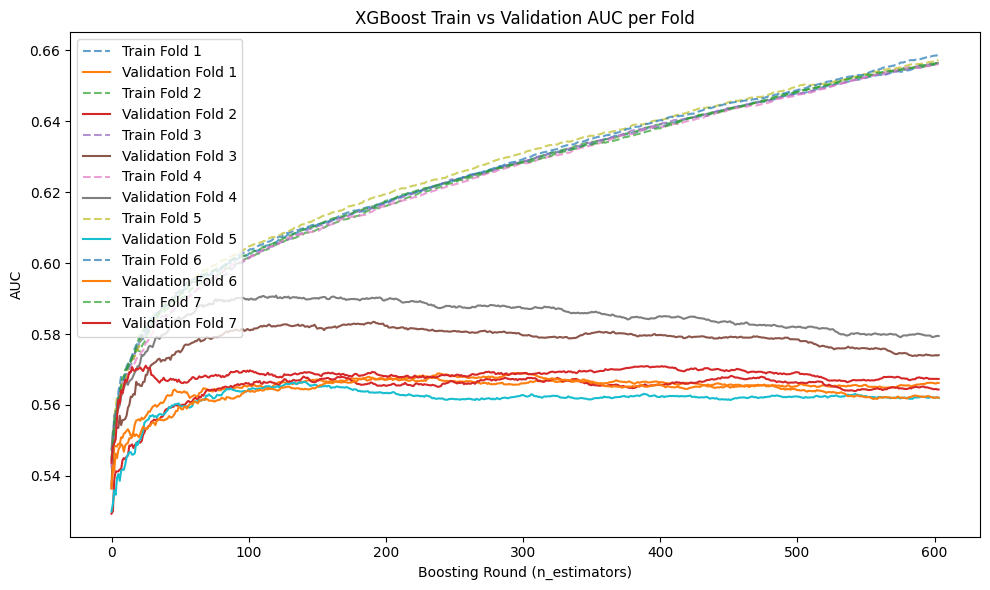


Plotting feature importance...


<Figure size 1000x600 with 0 Axes>

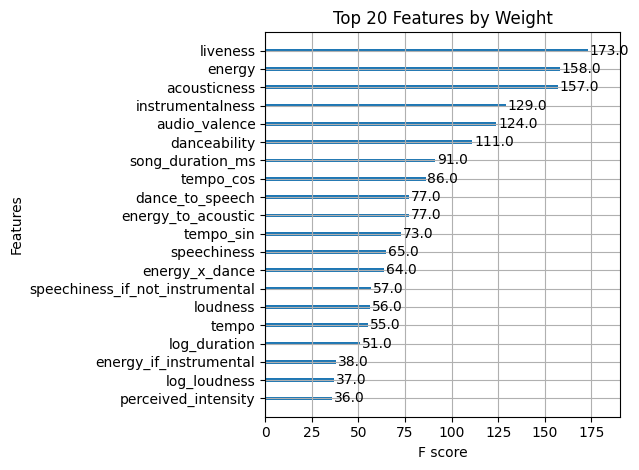

<Figure size 1000x600 with 0 Axes>

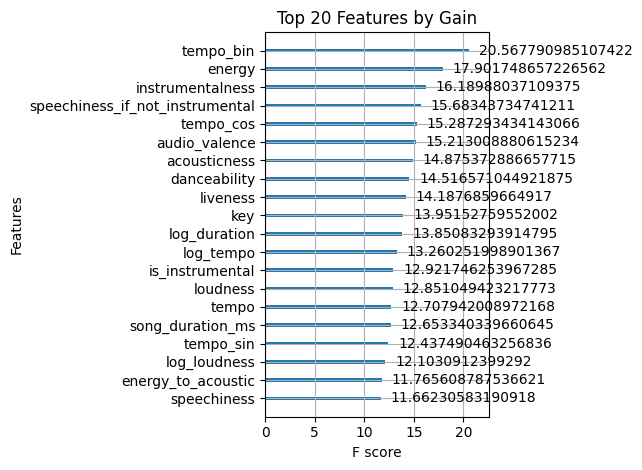

<Figure size 1000x600 with 0 Axes>

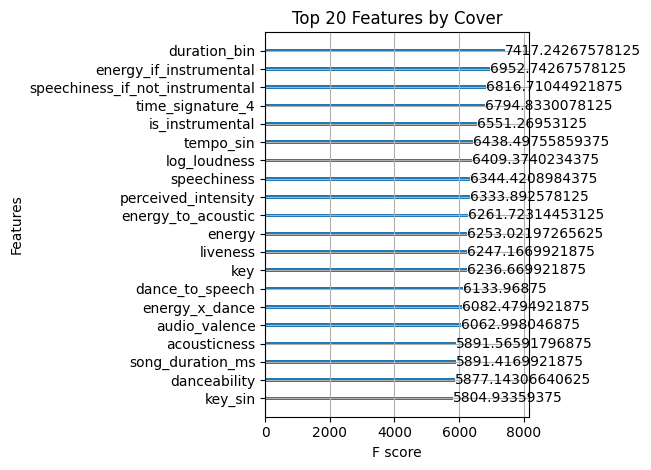


'submission_cv_optuna.csv' created successfully!


In [16]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# --- Load your train and test data ---
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

print("Preparing data...")
# --- Load cleaned train and test data ---
train = pd.read_csv("/kaggle/working/train_cleaned.csv")
test = pd.read_csv("/kaggle/working/test_cleaned.csv")

# --- Define train/test splits ---
X = train.drop(['id', 'song_popularity'], axis=1)
y = train['song_popularity']
X_test = test.drop('id', axis=1)[X.columns]   # ensure same columns
test_ids = test['id']

N_SPLITS = 7
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)


# --- Step 1: Define Objective Function for Optuna ---
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False,
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "early_stopping_rounds": 100,   
    }

    val_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        val_preds = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_preds)
        val_scores.append(val_auc)

    return np.mean(val_scores)


# --- Step 2: Run Optuna Optimization ---
print("Starting Optuna optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # adjust n_trials as needed

print("Best trial:")
print(study.best_trial.params)


# --- Step 3: Retrain with Best Parameters ---
best_params = study.best_trial.params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "use_label_encoder": False,
    "random_state": 42,
})

oof_preds = np.zeros(len(X))
test_preds = []
fold_eval_results = []
train_auc_scores = []
val_auc_scores = []

print(f"\nRetraining with best parameters using {N_SPLITS}-Fold CV...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(**best_params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    results = model.evals_result()
    fold_eval_results.append(results)

    val_preds = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_preds
    fold_test_preds = model.predict_proba(X_test)[:, 1]
    test_preds.append(fold_test_preds)

    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    val_auc = roc_auc_score(y_val, val_preds)
    train_auc_scores.append(train_auc)
    val_auc_scores.append(val_auc)
    print(f"Fold {fold+1} -> Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print("\n--- Training complete ---")
print("Average Train AUC:", np.mean(train_auc_scores))
print("Average Validation AUC:", np.mean(val_auc_scores))


# --- Step 4: Plot AUC Curves ---
plt.figure(figsize=(10, 6))
for i, results in enumerate(fold_eval_results):
    epochs = len(results['validation_0']['auc'])
    x_axis = range(0, epochs)

    plt.plot(x_axis, results['validation_0']['auc'],
             linestyle="--", alpha=0.7, label=f'Train Fold {i+1}')
    plt.plot(x_axis, results['validation_1']['auc'],
             label=f'Validation Fold {i+1}')

plt.xlabel('Boosting Round (n_estimators)')
plt.ylabel('AUC')
plt.title('XGBoost Train vs Validation AUC per Fold')
plt.legend()
plt.tight_layout()
plt.savefig("train_val_auc_curves_all_folds.png")
plt.show()


# --- Step 5: Feature Importance ---
print("\nPlotting feature importance...")
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X, y)  # fit on full training set

for importance_type in ["weight", "gain", "cover"]:
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(final_model, importance_type=importance_type, max_num_features=20)
    plt.title(f"Top 20 Features by {importance_type.capitalize()}")
    plt.tight_layout()
    plt.savefig(f"feature_importance_{importance_type}.png")
    plt.show()


# --- Step 6: Save Submission ---
final_predictions = np.mean(test_preds, axis=0)
submission_df = pd.DataFrame({
    'id': test_ids,
    'song_popularity': final_predictions
})
submission_df.to_csv("submission_cv_optuna.csv", index=False)
print("\n'submission_cv_optuna.csv' created successfully!")


In [2]:
!pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 437.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 65.0 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flask to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dash[testing] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of dash[testing] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of dash-boot

In [5]:
# --- 0. Installation ---
# Run this once to install the library
# !pip install pycaret[full]

# --- 1. Imports ---
import pandas as pd
from pycaret.classification import *

print("PyCaret and Pandas imported successfully.")

# --- 2. Configuration ---
# ⚠️ ACTION REQUIRED: Update these variables with your actual file paths and column names
TRAIN_FILE_PATH = '/kaggle/input/iisc-umc-301-kaggle-competition-1/train.csv'
TEST_FILE_PATH = '/kaggle/input/iisc-umc-301-kaggle-competition-1/test.csv'
SUBMISSION_FILE_PATH = '/kaggle/working/'
TARGET_COLUMN = 'song_popularity'
ID_COLUMN = 'id'


# --- 3. Load Data ---
try:
    print("🔄 Loading data...")
    train_df = pd.read_csv(TRAIN_FILE_PATH)
    test_df = pd.read_csv(TEST_FILE_PATH)
    submission_df = pd.read_csv(SUBMISSION_FILE_PATH)
    print("✅ Data loaded successfully!")
    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError:
    print("❌ ERROR: File not found. Please update the file paths in the 'Configuration' section.")
    exit()

# --- 4. Setup AutoML Experiment ---
print("\n🛠️ Setting up PyCaret experiment...")
# This initializes the environment and prepares data for modeling.
clf_experiment = setup(data=train_df, 
                       target=TARGET_COLUMN, 
                       session_id=42,  # for reproducibility
                       log_experiment=True, 
                       experiment_name='umc_kaggle_final',
                       ignore_features=[ID_COLUMN], 
                       use_gpu=False,
                       # Preprocessing steps
                       numeric_imputation='mean',
                       categorical_imputation='most_frequent',
                       normalize=True,
                       transformation=True)
print("✅ Experiment setup complete!")


# --- 5. Compare Models & Get Validation AUC ---
print("\n🚀 Comparing all models to find the best one...")
# This trains and evaluates all models, ranking them by AUC on the validation set.
# The printed table will show you the validation AUC for every model.
best_model = compare_models(sort='AUC')
print("✅ Model comparison complete!")
print("\n🏆 Best Model Found (based on validation AUC):")
print(best_model)


# --- 6. Tune the Best Model ---
print("\n튜닝 Tuning hyperparameters of the best model...")
# This function automatically tunes the hyperparameters of the selected model.
# The output table will show the validation AUC score for the tuned model.
tuned_model = tune_model(best_model)
print("✅ Hyperparameter tuning complete!")
print("\n✨ Tuned Model Details:")
print(tuned_model)


# --- 7. Finalize the Model ---
print("\n finalizing the model on the full training dataset...")
# Retrains the tuned model on the entire training data.
final_model = finalize_model(tuned_model)
print("✅ Model finalized!")


# --- 8. Make Predictions with Probabilities ---
print("\n🔮 Making predictions on the test set...")
# Generates predictions, including the probability scores.
predictions = predict_model(final_model, data=test_df)
print("✅ Predictions made!")
print("\nPreview of prediction results with probabilities:")
print(predictions.head())


# --- 9. Create Submission File ---
print("\n✍️ Creating final submission file...")
# Assign the probability scores (from the 'prediction_score' column) to the target column.
submission_df[TARGET_COLUMN] = predictions['prediction_score']

# Save the final submission file.
submission_filename = 'submission_final.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"🎉 Submission file '{submission_filename}' created successfully!")

CUDARuntimeError: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version